In [1]:
# import sys
# from importlib import reload
# reload(sys.modules["util.plot"])

from collections import defaultdict

import h5py

import numpy as np

import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from himalaya.scoring import correlation_score
from scipy.stats import pearsonr, zscore
from scipy.spatial.distance import cdist, pdist, squareform

from util import plot, subject, stats
from util.atlas import Atlas, get_brainmask
from constants import SUBS_STRANGERS, BLU, ORG, RUN_TRIAL_SLICE

# import warnings
# warnings.filterwarnings("ignore")

plt.style.use('figures.mplstyle')

In [2]:
%cd ..

/scratch/gpfs/zzada/fconv


In [3]:
cache = 'model9'
cache = 'default_task'
cache = 'default_task_trial'

FG_MASK = get_brainmask()

cachedir = f"results/cache/figurex-isc/{cache}/"
resultdir = f'figures/figure3/{cache}'
!mkdir -p $resultdir
!mkdir -p $cachedir

cachedir

'results/cache/figurex-isc/default_task_trial/'

# entire time series

In [5]:
def get_full_isc():
    iscs = []

    for subA in tqdm(SUBS_STRANGERS):

        dataA = subject.get_bold(subA, cache=cache)

        subB = subject.get_partner(subA)
        dataB = subject.get_bold(subB, cache=cache)

        iscs.append(correlation_score(dataA, dataB))

    sub_mbc = np.stack(iscs)
    
    return sub_mbc

In [ ]:
sub_full_isc = get_full_isc()
sub_full_isc.shape

In [7]:
# save
with h5py.File(f"{cachedir}/full_isc.hdf5", "w") as f:
    f.create_dataset(name="sub_full_isc", data=sub_full_isc)

In [5]:
# read
with h5py.File(f"{cachedir}/full_isc.hdf5", "r") as f:
    sub_full_isc = f["sub_full_isc"][...]

In [13]:
avg_isc = sub_full_isc.mean(0)

In [ ]:
sigmask = stats.ttest_1samp(sub_full_isc, method='fdr_bh', alpha=0.05)
sigmask.sum()

In [15]:
# save
with h5py.File(f"{cachedir}/full_isc_avg.hdf5", "w") as f:
    f.create_dataset(name="avg_isc", data=avg_isc)
    f.create_dataset(name="sigmask", data=sigmask)

In [ ]:
fig = plot.surface_plot(avg_isc, threshold=~sigmask, cmap='Spectral_r')#, vmax=.05)

# prod-comp

In [6]:
def get_mode_isc():
    prod_iscs = []

    for subA in tqdm(SUBS_STRANGERS):

        dataA = subject.get_bold(subA, cache=cache)
        prod_boxcar, _, _ = subject.get_timinglog_boxcars(subA)

        subB = subject.get_partner(subA)
        dataB = subject.get_bold(subB, cache=cache)

        prod_mask = prod_boxcar.astype(bool)
        prod_iscs.append(correlation_score(dataA[prod_mask], dataB[prod_mask]))

    sub_prod_isc = np.stack(prod_iscs)
    
    return sub_prod_isc

In [ ]:
sub_mode_isc = get_mode_isc()
sub_mode_isc.shape

In [9]:
# save
with h5py.File(f"{cachedir}/mode_isc.hdf5", "w") as f:
    f.create_dataset(name="sub_mode_isc", data=sub_mode_isc)
    # f.create_dataset(name="sigmask", data=sigmask)

In [ ]:
# read
with h5py.File(f"{cachedir}/mode_isc.hdf5", "r") as f:
    sub_mode_isc = f["sub_mode_isc"][...]
sub_mode_isc.shape

In [ ]:
sigmask = stats.ttest_1samp(sub_mode_isc, method='fdr_bh', alpha=0.05)
sigmask.sum()

In [ ]:
avg_mode_isc = sub_mode_isc.mean(0)
print(avg_mode_isc.min(), avg_mode_isc.max())
print(avg_mode_isc[sigmask].min(), avg_mode_isc[sigmask].max())

In [ ]:
fig, axes = plot.two_brain_fig(dpi=300)
plot.surface_plot(avg_mode_isc, cmap='inferno', vmin=0, fig=fig, ax=axes[0])
plot.surface_plot(avg_mode_isc, cmap='bwr', fig=fig, ax=axes[1])
fig.show()

In [ ]:
# fig = plot.surface_plot(avg_mode_isc, threshold=~sigmask, cmap='bwr')#, vmax=.05)
fig = plot.surface_plot(avg_mode_isc, threshold=~sigmask, cmap='inferno', vmin=0, vmax=.05)
# fig.savefig(f'{resultdir}/isc-prod-comp.svg')
fig.show()

# lagged entire time-series

In [ ]:
from util.signal import xcorr

In [ ]:
lags = np.arange(-10, 11)
lags * 1.5

In [ ]:
catlas = Atlas.load("custom_glasser_group")
# catlas = Atlas.load("custom_glasser")
# catlas = Atlas.schaefer()
len(catlas)

In [ ]:
sub_mbc_scores = []

for subA in tqdm(SUBS_STRANGERS[:29]):

    dataA = subject.get_bold(subA, cache=cache)

    prod_boxcar, _, _ = subject.get_timinglog_boxcars(subA)
    prod_mask = prod_boxcar.astype(bool)

    subB = subject.get_partner(subA)
    dataB = subject.get_bold(subB, cache=cache)

    dataA = catlas.vox_to_parc(dataA)
    dataB = catlas.vox_to_parc(dataB)

    sub_scores = np.zeros((10, len(lags), dataA.shape[-1]), dtype=np.float32)
    for k, t in enumerate(range(0, 1200, 120)):
        trial_slice = slice(t, t+120) 
        dataA_trial = dataA[trial_slice]
        dataB_trial = dataB[trial_slice]

        for i in range(dataA.shape[-1]):
            corrs, _ = xcorr(dataA_trial[..., i], dataB_trial[..., i], maxlags=len(lags)//2)
            sub_scores[k, :, i] = corrs

        # for i, lag in enumerate(lags):
        #     if lag < 0:
        #         trialA = dataA_trial[:lag]
        #         trialB = dataB_trial[-lag:]
        #     elif lag > 0:
        #         trialA = dataA_trial[lag:]
        #         trialB = dataB_trial[:-lag]
        #     else:
        #         trialA = dataA_trial
        #         trialB = dataB_trial
        #     sub_scores[k, i] = correlation_score(trialA, trialB)

    sub_mbc_scores.append(sub_scores)

sub_mbc_prod = np.stack(sub_mbc_scores)
sub_mbc_prod.shape

In [ ]:
# ONLY XCORR PROD-COMP CHUNKS

sub_mbc_scores = []

for subA in tqdm(SUBS_STRANGERS):

    dataA = subject.get_bold(subA, cache=cache)
    prod_boxcar, _, _ = subject.get_timinglog_boxcars(subA)
    prod_mask = prod_boxcar.astype(bool)

    subB = subject.get_partner(subA)
    dataB = subject.get_bold(subB, cache=cache)

    dataA = catlas.vox_to_parc(dataA)
    dataB = catlas.vox_to_parc(dataB)

    sub_scores = np.zeros((10, dataA.shape[-1], len(lags)), dtype=np.float32)
    for k, t in enumerate(range(0, 1200, 120)):
        trial_slice = slice(t, t+120) 
        dataA_trial = dataA[trial_slice]
        dataB_trial = dataB[trial_slice]
        pmask_trial = prod_mask[trial_slice]

        all_xcorrs = []
        chunk_bounds = np.diff(pmask_trial, prepend=0).nonzero()[0]
        if pmask_trial.all():
            chunk_bounds = [0, 120]

        if not pmask_trial.any(): # didn't speak at all in this trial
            continue

        for i in range(0, len(chunk_bounds), 2):
            from_idx = chunk_bounds[i] + 1
            to_idx = chunk_bounds[i+1] if i+1 < len(chunk_bounds) else 120

            chunk_size = to_idx - from_idx
            if chunk_size < 7:  # NOTE arbitrary threshold
                continue
            
            # NOTE arbitrary margin
            chunk_slice = slice(max(0, from_idx - 6),
                                min(120, to_idx + 6))

            dataA_chunk = dataA_trial[chunk_slice]
            dataB_chunk = dataB_trial[chunk_slice]

            # loop through each ROI
            roi_xcorrs = []
            for j in range(dataA_chunk.shape[-1]):
                corrs, _ = xcorr(dataA_chunk[..., j],
                                 dataB_chunk[..., j],
                                 maxlags=len(lags)//2)
                roi_xcorrs.append(corrs)
            all_xcorrs.append(roi_xcorrs)

        all_xcorrs = np.stack(all_xcorrs)
        sub_scores[k] = all_xcorrs.mean(0)  # average over chunks

        # print(subA, k, len(chunk_bounds), len(all_xcorrs))
        # print(subA, k, all_xcorrs.shape)

    sub_mbc_scores.append(sub_scores)

sub_mbc_prod = np.stack(sub_mbc_scores)
sub_mbc_prod.shape

In [27]:
# save
with h5py.File(f"{cachedir}/lagged_isc_entire.hdf5", "w") as f:
    f.create_dataset(name="sub_mbc_prod", data=sub_mbc_prod)

In [ ]:
avg_isc_lags = sub_mbc_prod.mean((0,1)).T  # NOTE transpose
avg_isc_lags.shape

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
for i, ax in enumerate(axes, start=9):
    print(i, lags[i])
    plot.surface_plot(
        catlas.parc_to_vox(avg_isc_lags[i]),
        cmap="Spectral_r",
        fig=fig,
        ax=ax,
        cbar=True,
        title=f"lag {lags[i]*1.5} s",
    )
fig.suptitle("ISC xcorr")
fig.show()

In [ ]:
for i, label in enumerate(catlas.labels):
    plt.figure(figsize=(2.8, 2))
    # plt.plot(lags, parcel_lags[:, i])
    plt.plot(lags, avg_isc_lags[:, i])
    plt.axvline(0, alpha=0.2, c='k')
    plt.ylim(-.1, .1)
    plt.title(label)
    plt.show()

In [ ]:
parcel_lags = catlas.vox_to_parc(avg_isc_lags)
parcel_lags.shape

In [ ]:
parcel_id = catlas['17Networks_LH_SomMotB_Aud_1']
parcel_id = catlas['17Networks_LH_DorsAttnA_TempOcc_10']
plt.plot(lags, avg_isc_lags[:, parcel_id])

# EAC QA

choose roi

In [4]:
glasser = Atlas.glasser2016()

857


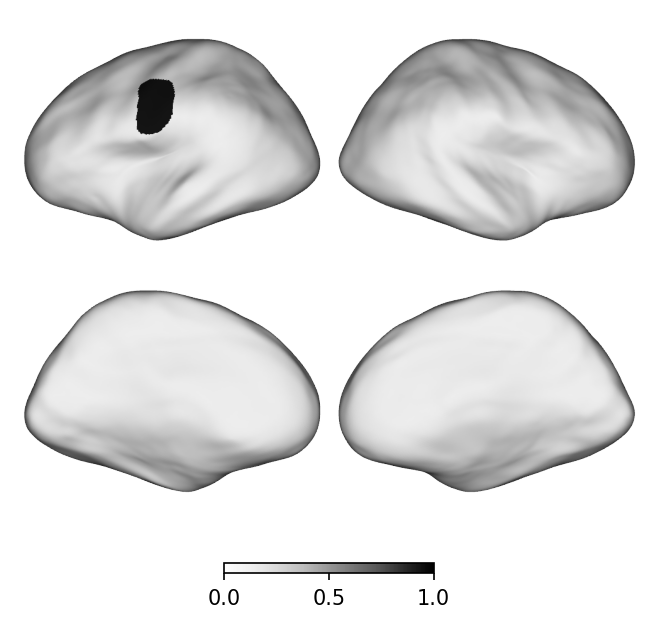

In [5]:
schaefer = Atlas.schaefer(100)
mot_mask = schaefer.roimask(['17Networks_LH_SomMotB_Cent_1'])

print(mot_mask.sum())
plot.surface_plot(mot_mask.astype(int), cmap='Grays', vmin=0, vmax=1, surf_lh_fn=None);

571


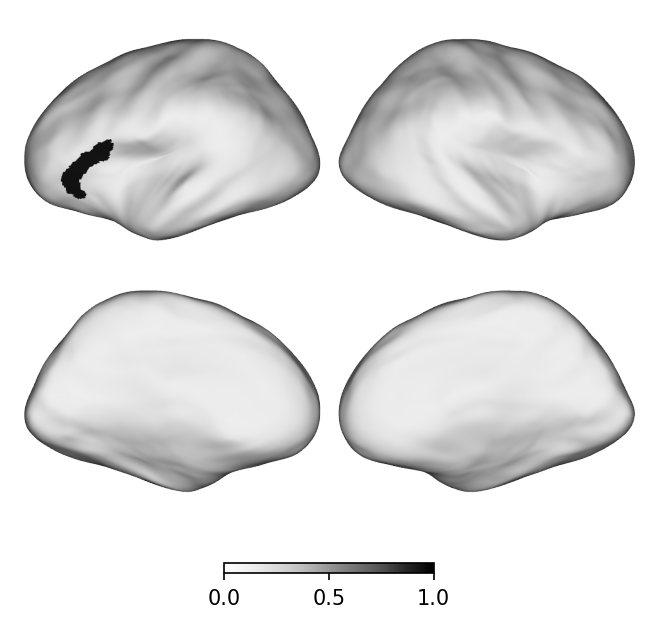

In [21]:
eac_mask = glasser.roimask(["L_A1", "L_LBelt", "L_MBelt", "L_PBelt", "L_RI"])
stg_mask = glasser.roimask(["L_A4", "L_A5", "L_STSda", "L_STSva", "L_STGa", "L_STSdp", "L_STSvp"])
pos_mask = glasser.roimask(["L_POS2"])
ifg_mask = glasser.roimask(["L_44", "L_45", "L_47l"])

# choose ROI
# roi_mask = eac_mask
# roi_mask = stg_mask
# roi_mask = pos_mask
roi_mask = ifg_mask

print(roi_mask.sum())
plot.surface_plot(roi_mask.astype(int), cmap='Grays', vmin=0, vmax=1, surf_lh_fn=None);

get data

In [22]:
eacs = []
for subA in tqdm(SUBS_STRANGERS):
    dataA = subject.get_bold(subA, cache=cache)
    eacs.append(dataA[:, roi_mask])

eacs = np.stack(eacs).mean(-1)
eacs.shape

100%|██████████| 58/58 [00:10<00:00,  5.30it/s]


(58, 1200)

In [38]:
sms = []
for subA in tqdm(SUBS_STRANGERS):
    dataA = subject.get_bold(subA, cache=cache)
    sms.append(dataA[:, mot_mask])

sms = np.stack(sms).mean(-1)
sms.shape

100%|██████████| 58/58 [00:16<00:00,  3.54it/s]


(58, 1200)

In [8]:
fds = []
for subA in tqdm(SUBS_STRANGERS):
    fd = subject.get_confounds(subA, model_spec=dict(confounds=['framewise_displacement']))
    fds.append(fd.squeeze())
fds = np.stack(fds)
fds.shape

  0%|          | 0/58 [00:00<?, ?it/s]

100%|██████████| 58/58 [00:24<00:00,  2.35it/s]


(58, 1200)

In [9]:
boxcars = []
for subA in tqdm(SUBS_STRANGERS):
    bc, _, _ = subject.get_timinglog_boxcars(subA)
    boxcars.append(bc.squeeze())
boxcars = np.stack(boxcars)
boxcars.shape

100%|██████████| 58/58 [00:00<00:00, 196.23it/s]


(58, 1200)

compute

In [25]:
trial_slice = slice(None)
# trial_slice = slice(0, 120)
# trial_slice = slice(120*4, 120*5)
trial_slice

slice(None, None, None)

In [76]:
sm_eac_sm = 1 - cdist(sms[:, trial_slice], eacs[:, trial_slice], metric='correlation')
np.fill_diagonal(sm_eac_sm, 0)
sm_eac_sm.shape

(58, 58)

In [26]:
isc_sv = 1 - pdist(eacs[:, trial_slice], metric='correlation')
fd_sv = 1 - pdist(fds[:, trial_slice], metric='correlation')
bc_sv = 1 - np.nan_to_num(pdist(boxcars[:, trial_slice], metric='correlation'))

sub_fds = fds[:, trial_slice].mean(-1)
sub_fd_sm = np.outer(sub_fds, sub_fds)
np.fill_diagonal(sub_fd_sm, 0)
sub_fd_sv = squareform(sub_fd_sm)

isc_sm = squareform(isc_sv)
fd_sm = squareform(fd_sv)
bc_sm = squareform(bc_sv)

trial_slice

slice(None, None, None)

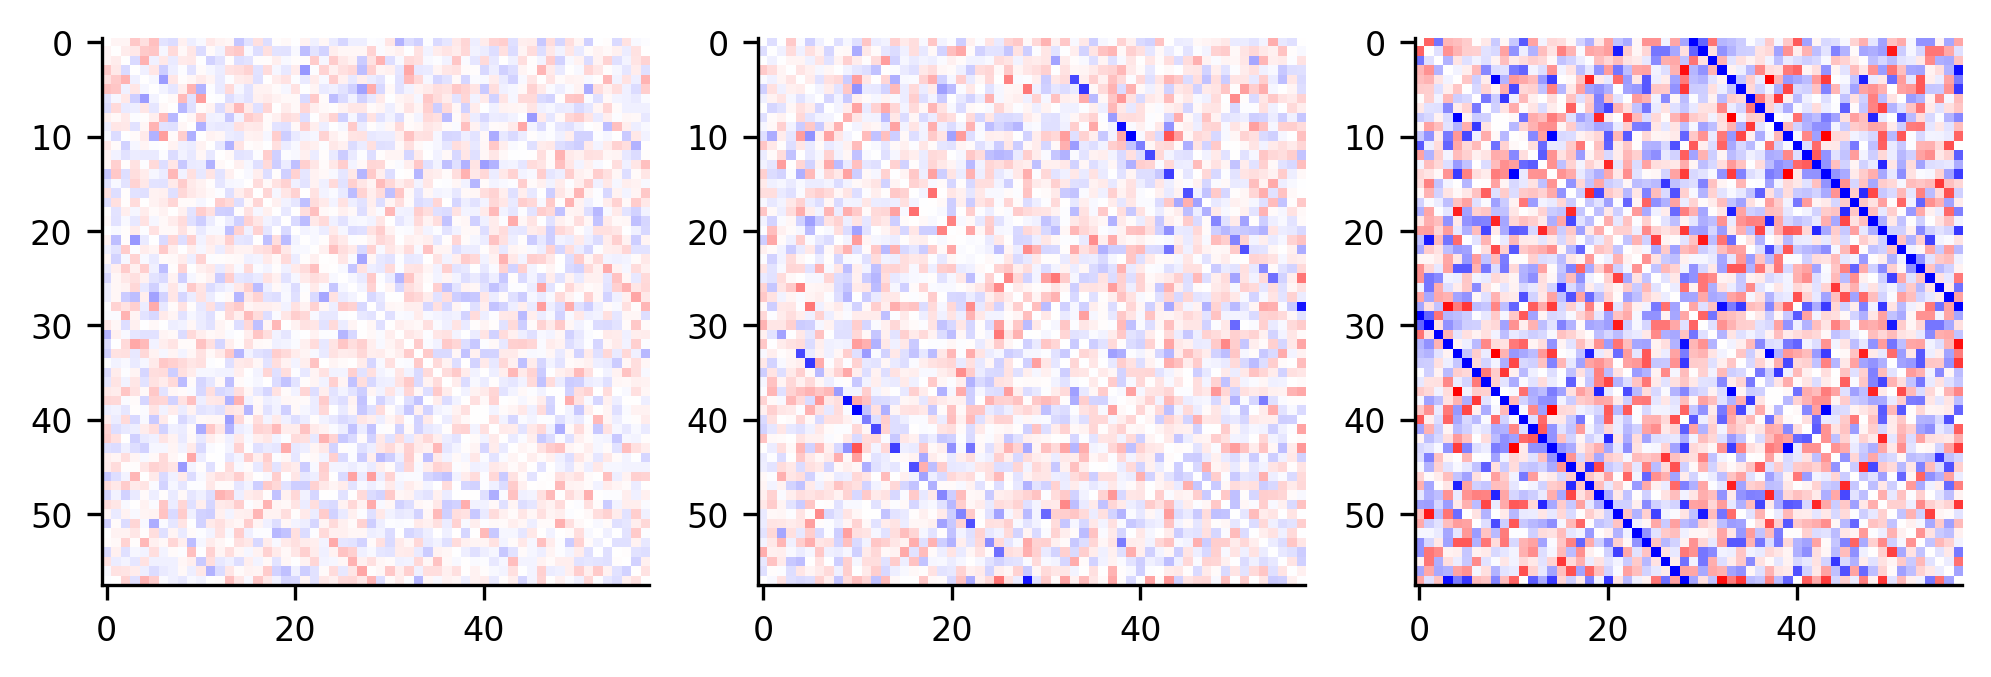

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(8,4), dpi=300)
axes[0].imshow(isc_sm, vmin=-0.3, vmax=0.3, cmap='bwr')
axes[1].imshow(fd_sm, vmin=-0.3, vmax=0.3, cmap='bwr')
axes[2].imshow(bc_sm , vmin=-0.3, vmax=0.3, cmap='bwr')
fig.show()

In [14]:
df = pd.DataFrame()
df['isc'] = isc_sv
df['fd'] = fd_sv
df['bc'] = bc_sv
df['sub_fd'] = sub_fd_sv

df.corr()

,isc,fd,bc,sub_fd
isc,1.000000,-0.020631,-0.101347,-0.010438
fd,-0.020631,1.000000,0.487258,-0.013126
bc,-0.101347,0.487258,1.000000,-0.001240
sub_fd,-0.010438,-0.013126,-0.001240,1.000000


In [75]:
C = 1 - cdist(fds[:, trial_slice], boxcars[:, trial_slice], metric='correlation')
C.shape

(58, 58)

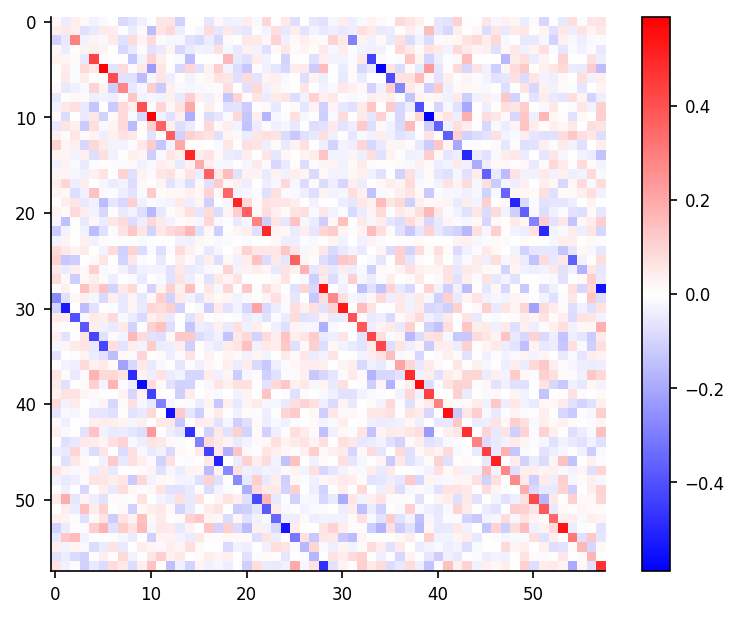

In [82]:
plt.imshow(C, cmap='bwr')
plt.colorbar()
plt.show()

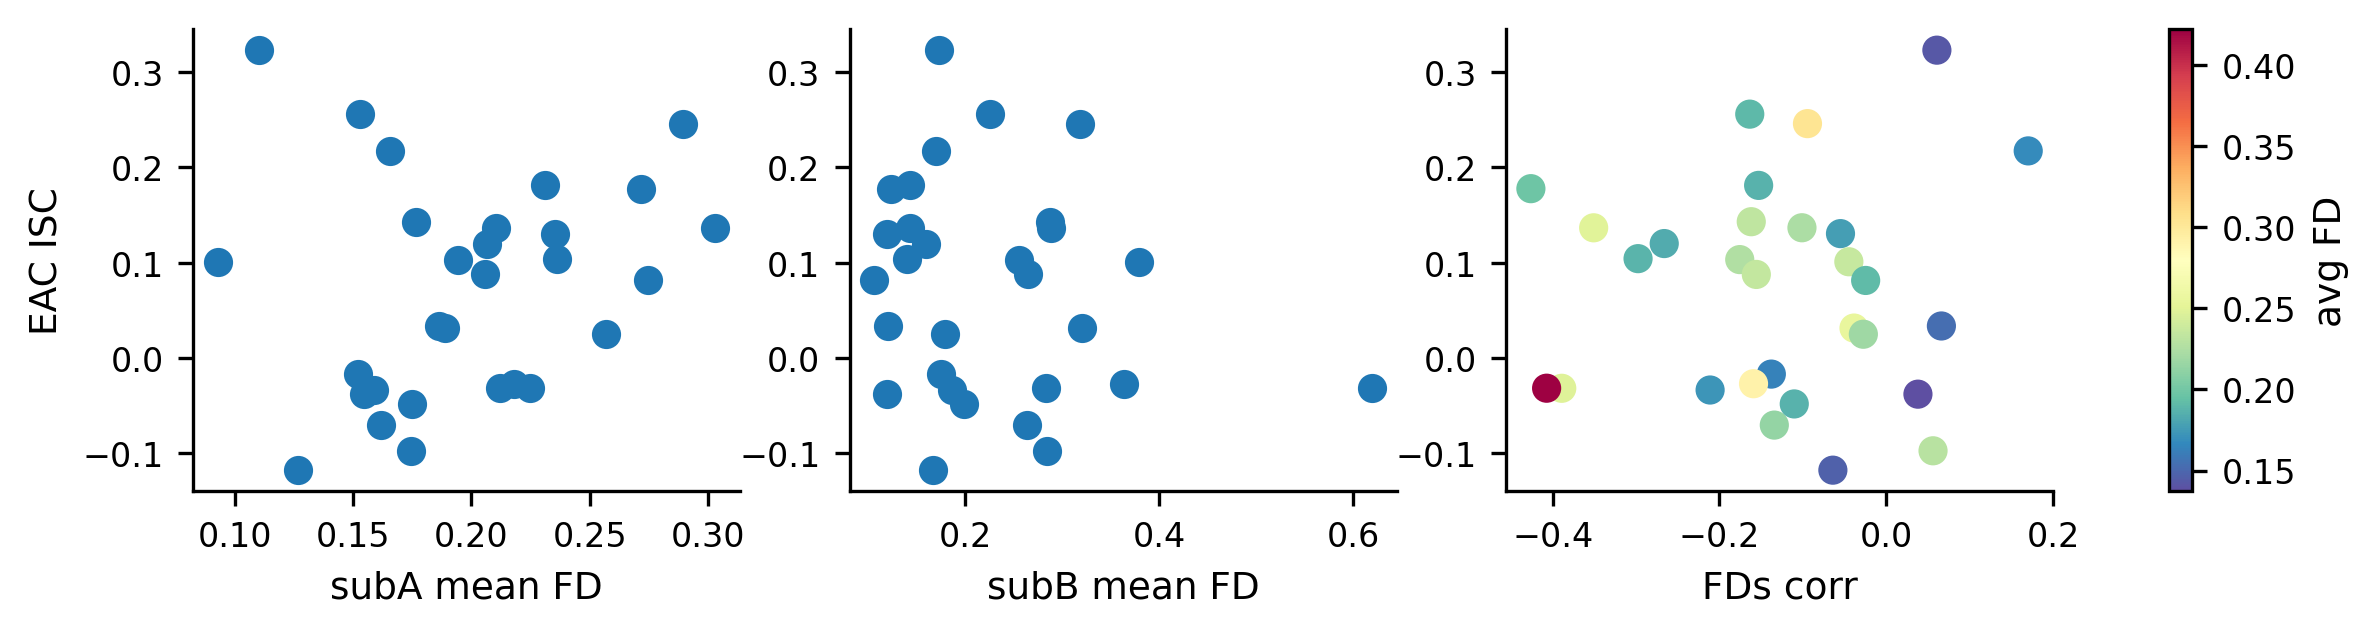

In [13]:
isc_vals = np.zeros(29)
fd_vals = np.zeros(29)
conv_fd = np.zeros(29)

for i in range(29):
    isc_vals[i] = isc_sm[i, i+29]
    fd_vals[i] = fd_sm[i, i+29]
    conv_fd[i] = (sub_fds[i] + sub_fds[i+29]) / 2
    # conv_fd[i] = max(sub_fds[i], sub_fds[i+29])

fig, axes = plt.subplots(1, 3, figsize=(10, 2), dpi=300)
axes[0].scatter(sub_fds[:29], isc_vals)
axes[1].scatter(sub_fds[29:], isc_vals)
im = axes[2].scatter(fd_vals, isc_vals, c=conv_fd, cmap='Spectral_r')
cbar = fig.colorbar(im, ax=axes)
cbar.ax.set_ylabel("avg FD")

axes[0].set_ylabel("EAC ISC")
axes[0].set_xlabel("subA mean FD")
axes[1].set_xlabel("subB mean FD")
axes[2].set_xlabel("FDs corr")
fig.show()

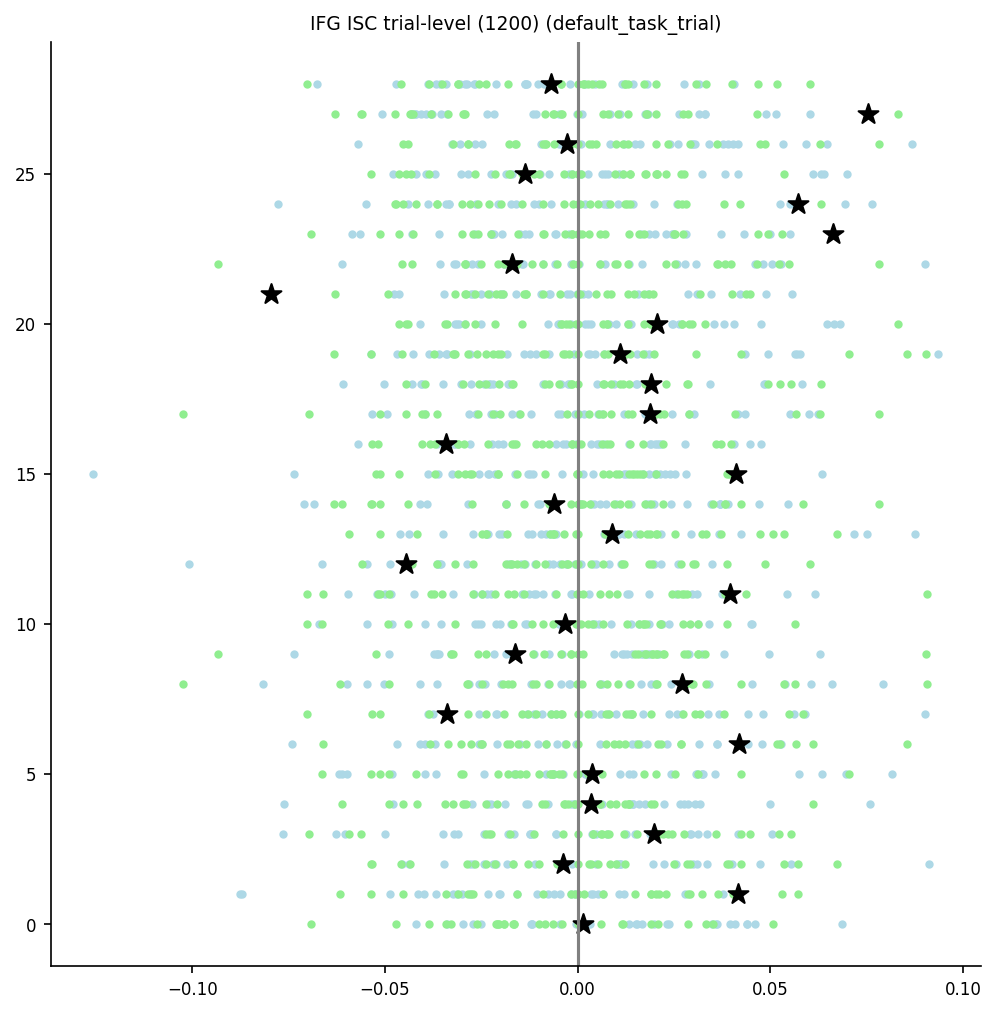

In [27]:
plt.figure(figsize=(8, 8))

for i, subA in enumerate(SUBS_STRANGERS[:29]):
    subB = subject.get_partner(subA)
    subB_id = SUBS_STRANGERS.index(subB)

    # corrsOthers = isc_sm[i]
    # plt.scatter(corrsOthers, np.ones(58) * i, c='gray', alpha=1.0);

    corrsOthersA = isc_sm[i, :29]
    corrsOthersB = isc_sm[i, 29:]

    # corrsOthersA = sm_eac_sm[i, :29]
    # corrsOthersB = sm_eac_sm[i, 29:]

    plt.scatter(corrsOthersB, np.ones(29) * i, c='lightblue', marker='.', alpha=1.0)
    plt.scatter(corrsOthersA, np.ones(29) * i, c='lightgreen', marker='.', alpha=1.0)

    corrPartner = isc_sm[i, subB_id]
    # corrPartner = sm_eac_sm[i, subB_id]
    plt.scatter(corrPartner, i, marker='*', s=100, c='black')

plt.title(f"IFG ISC trial-level (1200) ({cache})")
plt.axvline(0, c='gray')
plt.show()

dig into individual subject or pair

In [78]:
values = eacs[:, trial_slice]
values2 = sms[:, trial_slice]
# values = fds[:, trial_slice]
values.shape

(58, 120)

In [79]:
subA_id = 2
subB_id = subA_id + 29
# subC_id = isc_sm[subA_id].argmax()
subC_id = sm_eac_sm[subA_id].argmax()

subA = SUBS_STRANGERS[subA_id]
subB = SUBS_STRANGERS[subB_id]
subC = SUBS_STRANGERS[subC_id]

print('sub-*', subA, subB, subC)
print('index', subA_id, subB_id, subC_id)

# print(pearsonr(sms[subA_id, trial_slice], eacs[subB_id, trial_slice]))
# print(pearsonr(values[subA_id], values[subC_id]))
# print(pearsonr(values[subB_id], values[subC_id]))

print(pearsonr(sms[subA_id, trial_slice], eacs[subB_id, trial_slice]))
print(pearsonr(sms[subA_id, trial_slice], eacs[subC_id, trial_slice]))
print(pearsonr(sms[subB_id, trial_slice], eacs[subC_id, trial_slice]))

print("\nFD:")
print(pearsonr(fds[:, trial_slice][subA_id], fds[:, trial_slice][subB_id]))
print(pearsonr(fds[:, trial_slice][subA_id], fds[:, trial_slice][subC_id]))
print(pearsonr(fds[:, trial_slice][subB_id], fds[:, trial_slice][subC_id]))

print("\nBC:")
print(pearsonr(boxcars[:, trial_slice][subA_id], boxcars[:, trial_slice][subB_id]))
print(pearsonr(boxcars[:, trial_slice][subA_id], boxcars[:, trial_slice][subC_id]))
print(pearsonr(boxcars[:, trial_slice][subB_id], boxcars[:, trial_slice][subC_id]))

sub-* 106 6 58
index 2 31 55
PearsonRResult(statistic=-0.089353377695392, pvalue=0.3317898620390889)
PearsonRResult(statistic=0.20323015575113196, pvalue=0.025996799390967412)
PearsonRResult(statistic=-0.012719355501815233, pvalue=0.8903346776736999)

FD:
PearsonRResult(statistic=-0.08114545751352502, pvalue=0.3782886201531205)
PearsonRResult(statistic=-0.014592142101711829, pvalue=0.8743116581238681)
PearsonRResult(statistic=-0.0294757334858391, pvalue=0.7492865368579781)

BC:
PearsonRResult(statistic=-1.0, pvalue=0.0)
PearsonRResult(statistic=0.1216517748906199, pvalue=0.1856353853011117)
PearsonRResult(statistic=-0.1216517748906199, pvalue=0.1856353853011117)


In [86]:
dataA = subject.get_bold(subA, cache=cache)[trial_slice]
dataB = subject.get_bold(subB, cache=cache)[trial_slice]
dataC = subject.get_bold(subC, cache=cache)[trial_slice]

# dataA = glasser.vox_to_parc(dataA)
# dataB = glasser.vox_to_parc(dataB)
# dataC = glasser.vox_to_parc(dataC)

corrAB = correlation_score(dataA, dataB)
corrAC = correlation_score(dataA, dataC)
corrBC = correlation_score(dataB, dataC)

# corrAB = glasser.parc_to_vox(corrAB)
# corrAC = glasser.parc_to_vox(corrAC)
# corrBC = glasser.parc_to_vox(corrBC)

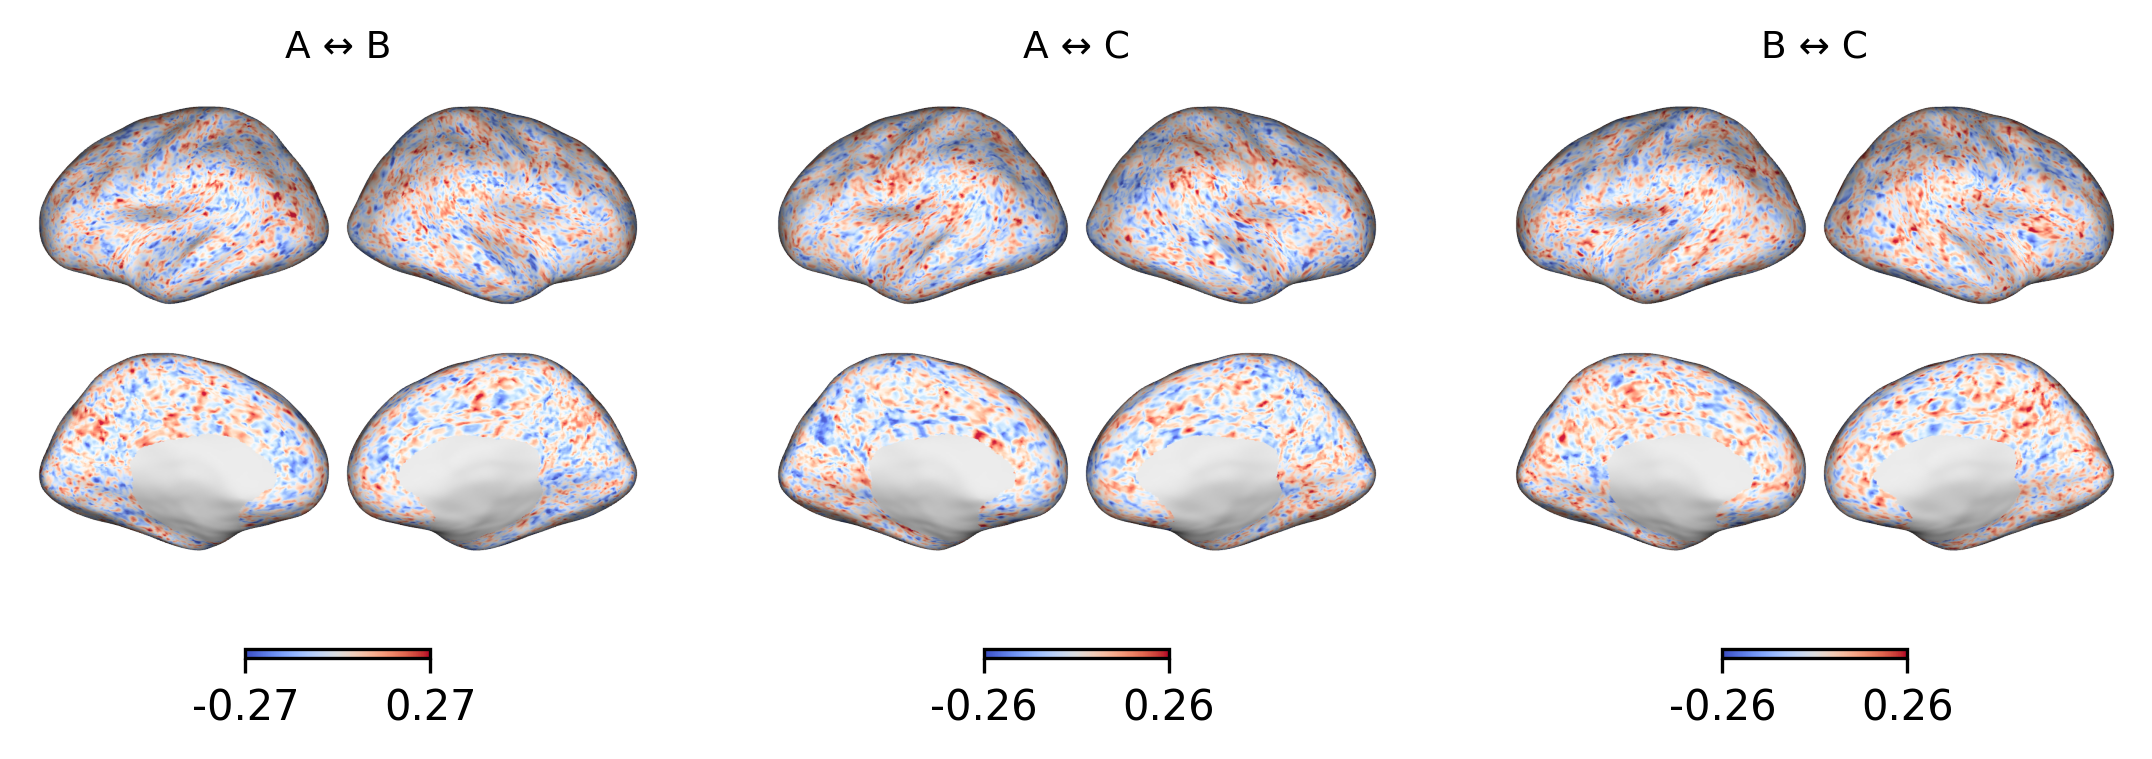

In [87]:
fig, axes = plt.subplots(1, 3, figsize=(9, 4), dpi=300)
plot.surface_plot(corrAB, fig=fig, ax=axes[0], vmax=None, title='A ↔ B', surf_lh_fn=None)
plot.surface_plot(corrAC, fig=fig, ax=axes[1], vmax=None, title='A ↔ C', surf_lh_fn=None)
plot.surface_plot(corrBC, fig=fig, ax=axes[2], vmax=None, title='B ↔ C', surf_lh_fn=None)
fig.show()

In [82]:
subA_prod_boxcar, _, _ = subject.get_timinglog_boxcars(subA)
subB_prod_boxcar, _, _ = subject.get_timinglog_boxcars(subB)
subC_prod_boxcar, _, _ = subject.get_timinglog_boxcars(subC)

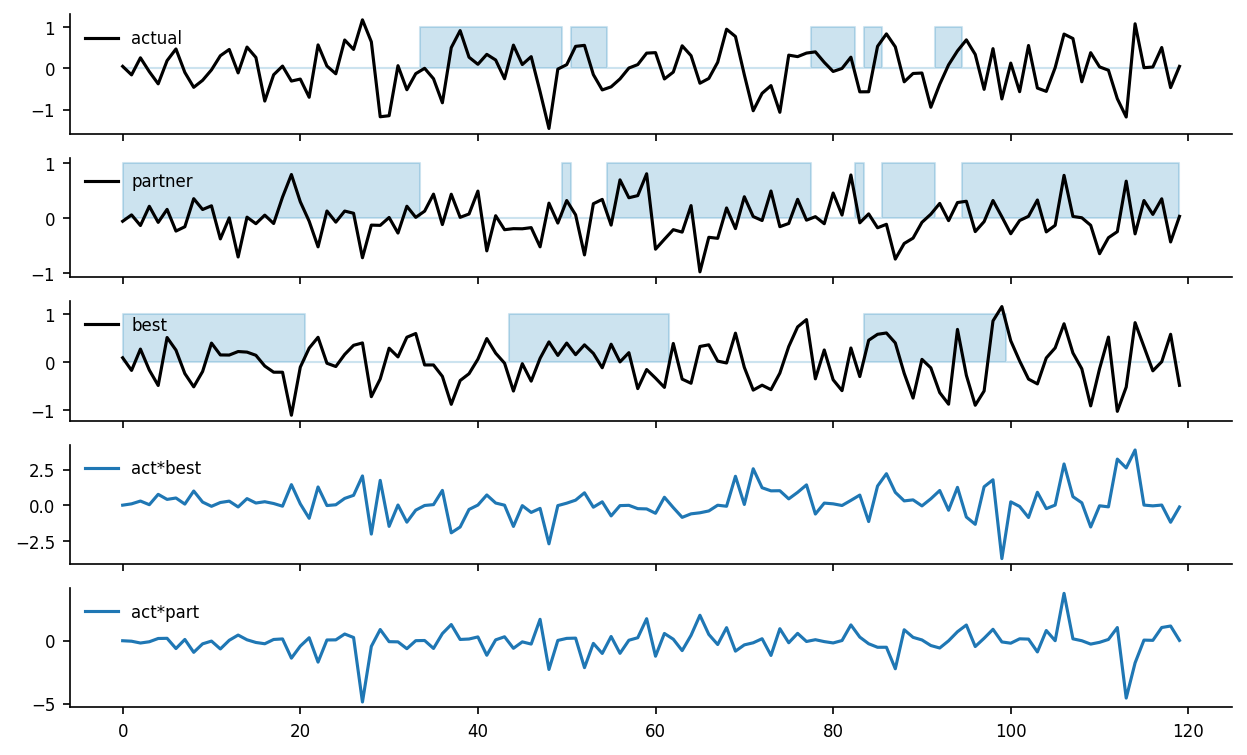

In [84]:
xaxis = np.arange(120)

fig, axes = plt.subplots(5, 1, figsize=(10, 6), sharex=True, sharey=not True)
# axes[0].plot(xaxis, values[subA_id], c='k', label='actual')
axes[0].plot(xaxis, sms[subA_id, trial_slice], c='k', label='actual')
axes[1].plot(xaxis, values[subB_id], c='k', label='partner')
axes[2].plot(xaxis, values[subC_id], c='k', label='best')

axes[3].plot(xaxis, zscore(sms[subA_id, trial_slice]) * zscore(values[subC_id]), label='act*best')
axes[4].plot(xaxis, zscore(sms[subA_id, trial_slice]) * zscore(values[subB_id]), label='act*part')

y = np.zeros(120)
axes[0].fill_between(xaxis, y, subA_prod_boxcar[:120], color=BLU, alpha=0.2, step="mid")
axes[1].fill_between(xaxis, y, subB_prod_boxcar[:120], color=BLU, alpha=0.2, step="mid")
axes[2].fill_between(xaxis, y, subC_prod_boxcar[:120], color=BLU, alpha=0.2, step="mid")

for ax in axes: ax.legend(loc='upper left')
fig.show()

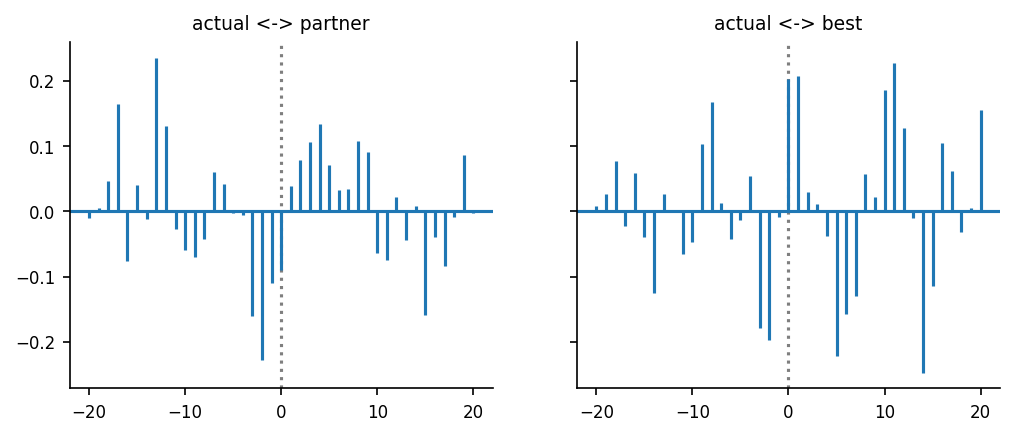

In [85]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 3))

axes[0].axvline(0, c='k', alpha=0.5, ls='dotted')
axes[1].axvline(0, c='k', alpha=0.5, ls='dotted')

axes[0].xcorr(sms[subA_id, trial_slice], values[subB_id], normed=True, usevlines=True, maxlags=20)
axes[1].xcorr(sms[subA_id, trial_slice], values[subC_id], normed=True, usevlines=True, maxlags=20)

axes[0].set_title("actual <-> partner")
axes[1].set_title("actual <-> best")

fig.show()

question: does regressing out variables from the entire run also make individual time points orthogonal to each variable?

In [6]:
from clean import CONFOUND_MODELS, get_timinglog_run_regressors
from constants import RUN_TRS, TR
from nilearn.glm.first_level import glover_hrf
from nilearn import signal

In [10]:
sub_id = 104
sub_id = 4
RUNS = [1]
model_params = CONFOUND_MODELS['default_task']

hrf = glover_hrf(TR, oversampling=1)

In [ ]:
dft = subject.get_timing(sub_id, condition=None)

clean_bold = []
run2trial = subject.get_trials(sub_id)
for run in RUNS:

    bold = subject.get_raw_bold(sub_id, runs=[run], trial_level=False)
    bold = bold.T

    confounds = subject.get_confounds(
        sub_id,
        runs=[run],
        trial_level=False,
        model_spec=model_params["confounds"],
    )
    dft_run = dft[dft.run == run]
    if model_params.get("add_task_confs", False):
        task_confounds = get_timinglog_run_regressors(sub_id, dft_run)
        task_confounds = [
            np.convolve(confound, hrf, mode="full")[:RUN_TRS]
            for confound in task_confounds
        ]
        task_confounds = np.stack(task_confounds).T
        confounds = np.hstack((confounds, task_confounds))

    cleaned_bold = signal.clean(
        bold,
        confounds=confounds,
        detrend=True,
        t_r=TR,
        ensure_finite=True,
        standardize="zscore_sample",
        standardize_confounds=True,
    )

    # slice out generate trials
    for trial in run2trial[run]:
        trial_slice = RUN_TRIAL_SLICE[trial]
        cleaned_bold_trial = cleaned_bold[trial_slice]
        zscored_bold_trial = np.nan_to_num(zscore(cleaned_bold_trial))
        clean_bold.append(zscored_bold_trial)

cleaned_bold_trials = np.vstack(clean_bold)
cleaned_bold_trials.shape 

In [12]:
# subA_trials = cleaned_bold_trials.copy()
subB_trials = cleaned_bold_trials.copy()

In [13]:
subA_eac_vox = subA_trials[:120, 27]
subB_eac_vox = subB_trials[:120, 27]

In [ ]:
pearsonr(subA_eac_vox, subB_eac_vox)

In [ ]:
eac_mask.nonzero()[0][0]

In [ ]:
confounds.shape, cleaned_bold.shape

In [ ]:
pearsonr(confounds[:, 4], cleaned_bold[:, 27])

In [ ]:
trial_slice

In [ ]:
pearsonr(confounds[trial_slice, 0], cleaned_bold[trial_slice, 27])

# ISC QA

(58, 56, 81924)
mean(axis=1)
max(axis=0)

then you get a map of random thresholds

In [ ]:
import numpy as np
from tqdm import tqdm
from util import subject
from himalaya.scoring import correlation_score
from constants import SUBS_STRANGERS

In [12]:
cache = 'default_task'
cache = 'default_task_trial'

In [ ]:
%cd ..

In [5]:
sub_data = {sub: subject.get_bold(sub, cache=cache) for sub in tqdm(SUBS_STRANGERS)}

  0%|          | 0/58 [00:00<?, ?it/s]

100%|██████████| 58/58 [00:10<00:00,  5.49it/s]


In [ ]:
scores = np.zeros((58, 56, 81924), dtype=np.float32)

for i, subA in enumerate(tqdm(SUBS_STRANGERS)):
    dataA = sub_data[subA]
    subB = subject.get_partner(subA)

    j = 0
    for subC in SUBS_STRANGERS:
        if subC == subA or subC == subB:
            continue

        dataC = sub_data[subC]
        scores[i, j] = correlation_score(dataA, dataC)
        j += 1

np.savez_compressed(f'scores_{cache}.npz', scores=scores)

In [33]:
scores = np.load(f'scores_{cache}.npz')['scores']
scores.shape

(58, 56, 81924)

0.020407613646239043


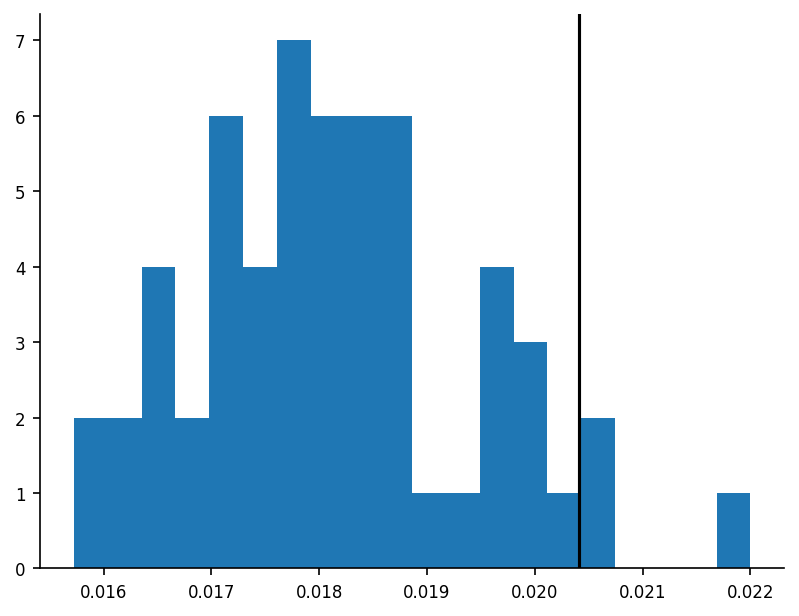

In [34]:
max_distribution = scores.mean(1).max(-1)
threshold = np.percentile(max_distribution, 95)
print(threshold)

plt.axvline(threshold, c='k')
plt.hist(max_distribution, bins=20)
plt.show()

In [13]:
max_avg_scores = scores.mean(1).max(0)
max_avg_scores.min(), max_avg_scores.max()

(0.0, 0.022000873)

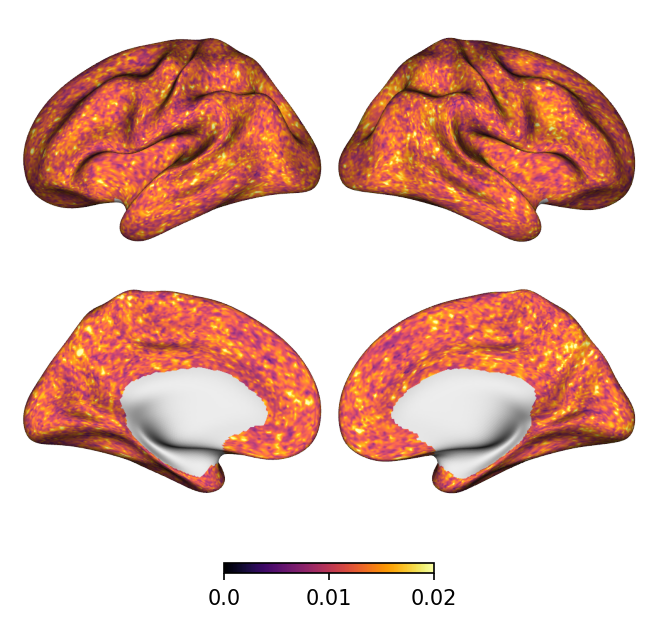

In [14]:
plot.surface_plot(max_avg_scores, vmin=0, cmap='inferno');

In [26]:
actual_scores = np.zeros((58, 81924), dtype=np.float32)

for i, subA in enumerate(tqdm(SUBS_STRANGERS)):
    dataA = sub_data[subA]
    subB = subject.get_partner(subA)
    # subB = SUBS_STRANGERS[(i+1) % len(SUBS_STRANGERS)]

    dataB = sub_data[subB]
    actual_scores[i] = correlation_score(dataA, dataB)

# np.savez_compressed(f'scores-actual_{cache}.npz', scores=actual_scores)
actual_scores.shape

  0%|          | 0/58 [00:00<?, ?it/s]

100%|██████████| 58/58 [02:11<00:00,  2.27s/it]


(58, 81924)

In [30]:
actual_scores = np.load(f'scores-actual_{cache}.npz')['scores']

In [31]:
avg_actual_score = actual_scores.mean(0)
avg_actual_score.min(), avg_actual_score.max()

(-0.036086984, 0.08310531)

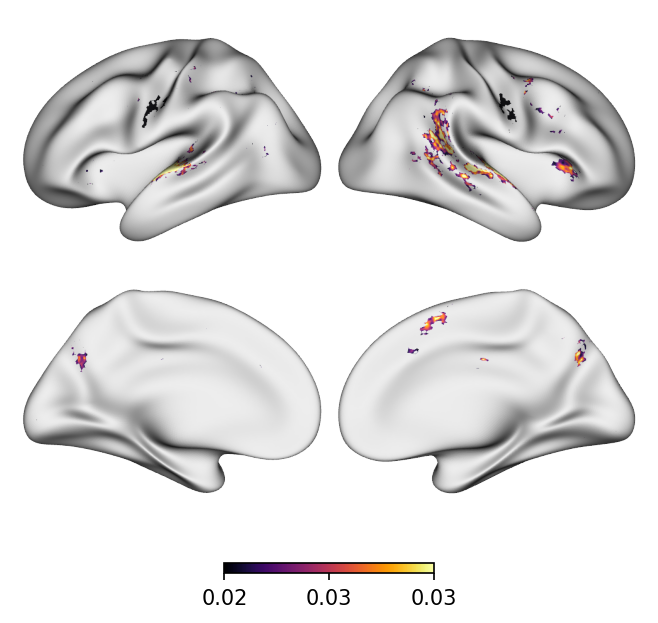

In [35]:
plot.surface_plot(avg_actual_score, vmin=threshold, threshold=threshold, cmap='inferno');
# plot.surface_plot(avg_actual_score, vmin=0, cmap='inferno');